# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
import subprocess
print(subprocess.run(["pip install tqdm"], stdout=subprocess.PIPE, shell=True).stdout.decode())

data_dir = './input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [21:13<00:00, 47.1File/s]  


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

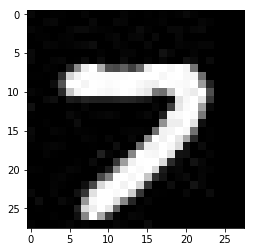

In [25]:
show_n_images = 1

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

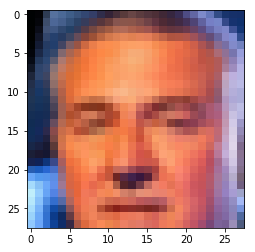

In [26]:
show_n_images = 1

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [28]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    z_inputs = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learn_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    
    return real_inputs, z_inputs, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [60]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
      
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d(relu3, 512, 3, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
      
        flatten = tf.reshape(relu3, (-1, 2*2*512))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
    
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [75]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    if is_train==True:
        reuse = False
    else:
        reuse = True
    
    with tf.variable_scope('generator', reuse=reuse):
        fcl = tf.layers.dense(z, 2*2*512)
        
        conv1 = tf.reshape(fcl, (-1, 2, 2, 512))
        batch_norm1 = tf.layers.batch_normalization(conv1, training=is_train)
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 3, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 4, strides=1, padding='valid')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(alpha * conv3, conv3)
        
        conv4 = tf.layers.conv2d_transpose(conv3, 64, 3, strides=2, padding='same')
        batch_norm4 = tf.layers.batch_normalization(conv4, training=is_train)
        relu4 = tf.maximum(alpha * conv4, conv4)
        
        logits = tf.layers.conv2d_transpose(conv4, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
    
    return output      

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [76]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [84]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [85]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [97]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
   # Set all variables to store the model functions
    _ , img_w, img_h, img_d = data_shape
    real_input, z_input, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Set additional params
    steps = 0
    losses = []
    print_every = 10
    show_every = 100
    figsize=(5,5)
    
    # Run tf.Session()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2.0
                steps += 1
                
                # Generate sample random noise for Generator
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: sample_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: sample_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: sample_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: sample_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, z_input, img_d, data_image_mode)
                    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2635... Generator Loss: 2.0091
Epoch 1/2... Discriminator Loss: 0.0722... Generator Loss: 3.7157
Epoch 1/2... Discriminator Loss: 3.9838... Generator Loss: 0.0928
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 1.0946
Epoch 1/2... Discriminator Loss: 0.5935... Generator Loss: 2.3015
Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 1.7266
Epoch 1/2... Discriminator Loss: 0.4503... Generator Loss: 1.3955
Epoch 1/2... Discriminator Loss: 0.5388... Generator Loss: 1.3617
Epoch 1/2... Discriminator Loss: 0.7353... Generator Loss: 3.2868
Epoch 1/2... Discriminator Loss: 0.5555... Generator Loss: 1.4351


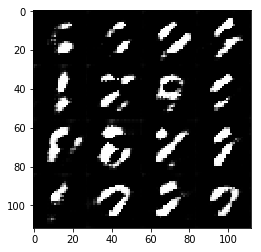

Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 2.6058
Epoch 1/2... Discriminator Loss: 0.4170... Generator Loss: 1.5449
Epoch 1/2... Discriminator Loss: 0.4296... Generator Loss: 2.8778
Epoch 1/2... Discriminator Loss: 0.4494... Generator Loss: 2.5296
Epoch 1/2... Discriminator Loss: 0.7433... Generator Loss: 0.9067
Epoch 1/2... Discriminator Loss: 0.3878... Generator Loss: 3.4421
Epoch 1/2... Discriminator Loss: 0.2774... Generator Loss: 2.8004
Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 1.0057
Epoch 1/2... Discriminator Loss: 0.6338... Generator Loss: 1.6094
Epoch 1/2... Discriminator Loss: 0.5866... Generator Loss: 1.7159


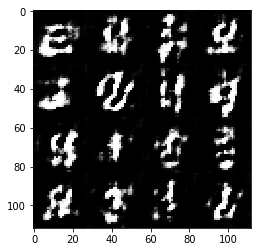

Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 1.8915
Epoch 1/2... Discriminator Loss: 0.5347... Generator Loss: 1.7874
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.3941
Epoch 1/2... Discriminator Loss: 0.5934... Generator Loss: 1.8847
Epoch 1/2... Discriminator Loss: 0.8547... Generator Loss: 0.8259
Epoch 1/2... Discriminator Loss: 0.5498... Generator Loss: 1.8874
Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 1.1852
Epoch 1/2... Discriminator Loss: 0.6502... Generator Loss: 1.1662
Epoch 1/2... Discriminator Loss: 0.4966... Generator Loss: 1.3549
Epoch 1/2... Discriminator Loss: 0.3556... Generator Loss: 2.1453


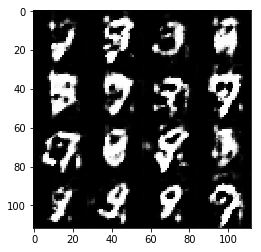

Epoch 1/2... Discriminator Loss: 0.5103... Generator Loss: 1.3695
Epoch 1/2... Discriminator Loss: 0.4875... Generator Loss: 1.4617
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 0.8371
Epoch 1/2... Discriminator Loss: 0.5436... Generator Loss: 1.2227
Epoch 1/2... Discriminator Loss: 0.3491... Generator Loss: 2.1023
Epoch 1/2... Discriminator Loss: 0.3154... Generator Loss: 2.1380
Epoch 1/2... Discriminator Loss: 0.3918... Generator Loss: 3.7980
Epoch 1/2... Discriminator Loss: 0.2415... Generator Loss: 2.6947
Epoch 1/2... Discriminator Loss: 0.2930... Generator Loss: 1.8680


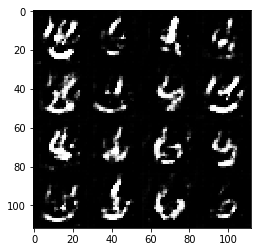

Epoch 1/2... Discriminator Loss: 0.2049... Generator Loss: 2.4533
Epoch 1/2... Discriminator Loss: 0.2517... Generator Loss: 2.0176
Epoch 1/2... Discriminator Loss: 0.1978... Generator Loss: 2.4444
Epoch 1/2... Discriminator Loss: 0.2891... Generator Loss: 1.9588
Epoch 1/2... Discriminator Loss: 0.1444... Generator Loss: 3.0299
Epoch 1/2... Discriminator Loss: 0.2121... Generator Loss: 2.2218
Epoch 1/2... Discriminator Loss: 0.3767... Generator Loss: 1.7654
Epoch 1/2... Discriminator Loss: 0.3576... Generator Loss: 1.7622
Epoch 1/2... Discriminator Loss: 0.3357... Generator Loss: 1.9769


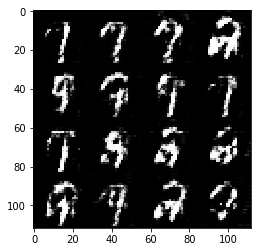

Epoch 1/2... Discriminator Loss: 0.2984... Generator Loss: 2.2798
Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 6.3366
Epoch 1/2... Discriminator Loss: 0.2706... Generator Loss: 2.3769
Epoch 1/2... Discriminator Loss: 0.4750... Generator Loss: 1.3374
Epoch 1/2... Discriminator Loss: 0.3780... Generator Loss: 1.7918
Epoch 1/2... Discriminator Loss: 0.1706... Generator Loss: 2.4980
Epoch 1/2... Discriminator Loss: 0.1743... Generator Loss: 2.6328
Epoch 1/2... Discriminator Loss: 0.1252... Generator Loss: 3.1329
Epoch 1/2... Discriminator Loss: 0.1494... Generator Loss: 2.9776
Epoch 1/2... Discriminator Loss: 0.1510... Generator Loss: 2.7288


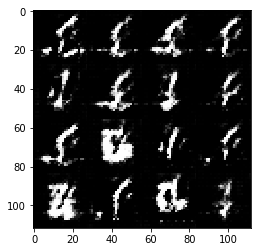

Epoch 1/2... Discriminator Loss: 0.0737... Generator Loss: 3.4745
Epoch 1/2... Discriminator Loss: 0.2412... Generator Loss: 2.2868
Epoch 1/2... Discriminator Loss: 0.3751... Generator Loss: 1.6928
Epoch 1/2... Discriminator Loss: 0.3579... Generator Loss: 1.9265
Epoch 1/2... Discriminator Loss: 0.3952... Generator Loss: 2.3545
Epoch 1/2... Discriminator Loss: 0.3320... Generator Loss: 2.0163
Epoch 1/2... Discriminator Loss: 0.3117... Generator Loss: 2.1134
Epoch 1/2... Discriminator Loss: 0.4222... Generator Loss: 3.8756
Epoch 1/2... Discriminator Loss: 0.2670... Generator Loss: 2.3291
Epoch 1/2... Discriminator Loss: 0.2073... Generator Loss: 3.1085


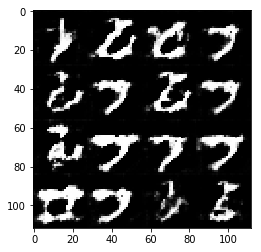

Epoch 1/2... Discriminator Loss: 0.2092... Generator Loss: 2.1720
Epoch 1/2... Discriminator Loss: 0.1906... Generator Loss: 3.1467
Epoch 1/2... Discriminator Loss: 0.2226... Generator Loss: 2.3653
Epoch 1/2... Discriminator Loss: 0.2896... Generator Loss: 1.9341
Epoch 1/2... Discriminator Loss: 0.3224... Generator Loss: 1.6994
Epoch 1/2... Discriminator Loss: 0.1495... Generator Loss: 2.9834
Epoch 1/2... Discriminator Loss: 0.1825... Generator Loss: 2.5684
Epoch 1/2... Discriminator Loss: 0.1576... Generator Loss: 2.6952
Epoch 1/2... Discriminator Loss: 0.1839... Generator Loss: 2.4212
Epoch 1/2... Discriminator Loss: 0.1394... Generator Loss: 5.5580


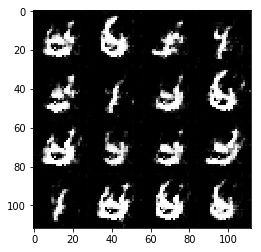

Epoch 1/2... Discriminator Loss: 0.1044... Generator Loss: 3.2272
Epoch 1/2... Discriminator Loss: 0.1399... Generator Loss: 3.2579
Epoch 1/2... Discriminator Loss: 0.0794... Generator Loss: 3.8470
Epoch 1/2... Discriminator Loss: 0.1206... Generator Loss: 3.6473
Epoch 1/2... Discriminator Loss: 0.2978... Generator Loss: 1.9878
Epoch 1/2... Discriminator Loss: 0.3180... Generator Loss: 1.8550
Epoch 1/2... Discriminator Loss: 0.0900... Generator Loss: 3.1999
Epoch 1/2... Discriminator Loss: 0.2110... Generator Loss: 2.3354
Epoch 1/2... Discriminator Loss: 0.2185... Generator Loss: 3.2077
Epoch 1/2... Discriminator Loss: 0.1649... Generator Loss: 2.5932


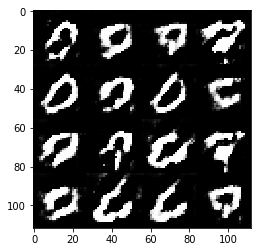

Epoch 1/2... Discriminator Loss: 0.1098... Generator Loss: 3.1952
Epoch 1/2... Discriminator Loss: 0.1243... Generator Loss: 3.2215
Epoch 1/2... Discriminator Loss: 0.2046... Generator Loss: 2.4427
Epoch 2/2... Discriminator Loss: 0.2627... Generator Loss: 2.1208
Epoch 2/2... Discriminator Loss: 0.3577... Generator Loss: 1.6448
Epoch 2/2... Discriminator Loss: 0.4230... Generator Loss: 2.0112
Epoch 2/2... Discriminator Loss: 0.1046... Generator Loss: 3.6273
Epoch 2/2... Discriminator Loss: 0.1016... Generator Loss: 3.5759
Epoch 2/2... Discriminator Loss: 0.1006... Generator Loss: 3.8277
Epoch 2/2... Discriminator Loss: 0.2899... Generator Loss: 4.5233


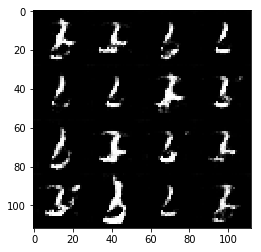

Epoch 2/2... Discriminator Loss: 0.0797... Generator Loss: 3.4920
Epoch 2/2... Discriminator Loss: 0.1912... Generator Loss: 3.0258
Epoch 2/2... Discriminator Loss: 0.1177... Generator Loss: 3.3050
Epoch 2/2... Discriminator Loss: 0.1017... Generator Loss: 3.3586
Epoch 2/2... Discriminator Loss: 0.1882... Generator Loss: 2.5839
Epoch 2/2... Discriminator Loss: 0.1556... Generator Loss: 3.1205
Epoch 2/2... Discriminator Loss: 0.0509... Generator Loss: 4.1952
Epoch 2/2... Discriminator Loss: 0.1597... Generator Loss: 2.9510
Epoch 2/2... Discriminator Loss: 0.1616... Generator Loss: 3.1767
Epoch 2/2... Discriminator Loss: 0.1767... Generator Loss: 2.9080


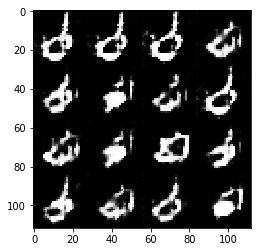

Epoch 2/2... Discriminator Loss: 0.0464... Generator Loss: 3.8170
Epoch 2/2... Discriminator Loss: 0.0644... Generator Loss: 3.5940
Epoch 2/2... Discriminator Loss: 0.1665... Generator Loss: 5.4644
Epoch 2/2... Discriminator Loss: 0.1539... Generator Loss: 3.0732
Epoch 2/2... Discriminator Loss: 0.0721... Generator Loss: 3.6862
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 8.5264
Epoch 2/2... Discriminator Loss: 0.0758... Generator Loss: 3.8886
Epoch 2/2... Discriminator Loss: 0.1585... Generator Loss: 3.8194
Epoch 2/2... Discriminator Loss: 0.1139... Generator Loss: 3.0413
Epoch 2/2... Discriminator Loss: 0.0836... Generator Loss: 3.6869


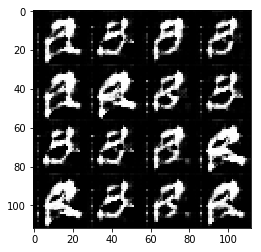

Epoch 2/2... Discriminator Loss: 0.1190... Generator Loss: 2.8794
Epoch 2/2... Discriminator Loss: 0.4390... Generator Loss: 1.8100
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 1.1195
Epoch 2/2... Discriminator Loss: 0.2345... Generator Loss: 2.4998
Epoch 2/2... Discriminator Loss: 0.1075... Generator Loss: 3.3785
Epoch 2/2... Discriminator Loss: 0.1240... Generator Loss: 3.1122
Epoch 2/2... Discriminator Loss: 0.0739... Generator Loss: 3.7234
Epoch 2/2... Discriminator Loss: 0.1701... Generator Loss: 3.1238
Epoch 2/2... Discriminator Loss: 0.1065... Generator Loss: 4.1123
Epoch 2/2... Discriminator Loss: 0.1030... Generator Loss: 3.1485


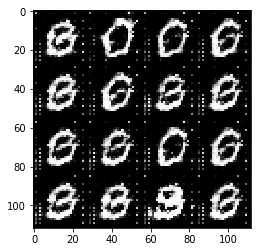

Epoch 2/2... Discriminator Loss: 0.2043... Generator Loss: 2.9707
Epoch 2/2... Discriminator Loss: 0.1831... Generator Loss: 2.4408
Epoch 2/2... Discriminator Loss: 0.1049... Generator Loss: 3.0793
Epoch 2/2... Discriminator Loss: 0.1800... Generator Loss: 3.0666
Epoch 2/2... Discriminator Loss: 0.1808... Generator Loss: 6.1395
Epoch 2/2... Discriminator Loss: 0.0773... Generator Loss: 3.7187
Epoch 2/2... Discriminator Loss: 0.1887... Generator Loss: 2.0480
Epoch 2/2... Discriminator Loss: 0.0687... Generator Loss: 4.1417
Epoch 2/2... Discriminator Loss: 0.1307... Generator Loss: 4.0738
Epoch 2/2... Discriminator Loss: 0.1979... Generator Loss: 2.4738


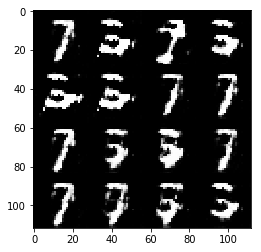

Epoch 2/2... Discriminator Loss: 0.0901... Generator Loss: 3.5264
Epoch 2/2... Discriminator Loss: 0.0387... Generator Loss: 3.9339
Epoch 2/2... Discriminator Loss: 0.0720... Generator Loss: 3.3595
Epoch 2/2... Discriminator Loss: 0.1107... Generator Loss: 3.2898
Epoch 2/2... Discriminator Loss: 0.0502... Generator Loss: 4.0690
Epoch 2/2... Discriminator Loss: 0.1217... Generator Loss: 4.0281
Epoch 2/2... Discriminator Loss: 0.1786... Generator Loss: 3.1023
Epoch 2/2... Discriminator Loss: 0.1656... Generator Loss: 2.4103
Epoch 2/2... Discriminator Loss: 0.1379... Generator Loss: 2.5693
Epoch 2/2... Discriminator Loss: 0.1073... Generator Loss: 2.9935


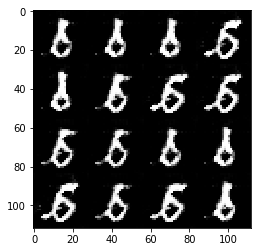

Epoch 2/2... Discriminator Loss: 0.2827... Generator Loss: 2.0025
Epoch 2/2... Discriminator Loss: 0.0524... Generator Loss: 3.9291
Epoch 2/2... Discriminator Loss: 0.0555... Generator Loss: 3.6340
Epoch 2/2... Discriminator Loss: 0.0704... Generator Loss: 3.0809
Epoch 2/2... Discriminator Loss: 0.0715... Generator Loss: 3.3994
Epoch 2/2... Discriminator Loss: 0.0233... Generator Loss: 5.6708
Epoch 2/2... Discriminator Loss: 0.1003... Generator Loss: 4.0146
Epoch 2/2... Discriminator Loss: 0.0953... Generator Loss: 2.8963
Epoch 2/2... Discriminator Loss: 0.0252... Generator Loss: 5.0811
Epoch 2/2... Discriminator Loss: 0.1054... Generator Loss: 3.4102


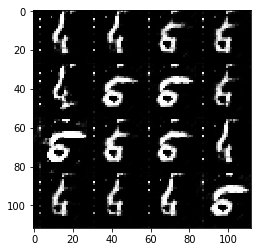

Epoch 2/2... Discriminator Loss: 0.0670... Generator Loss: 4.3727
Epoch 2/2... Discriminator Loss: 0.0402... Generator Loss: 4.1534
Epoch 2/2... Discriminator Loss: 0.0555... Generator Loss: 4.5043
Epoch 2/2... Discriminator Loss: 0.3935... Generator Loss: 3.8725
Epoch 2/2... Discriminator Loss: 0.2238... Generator Loss: 2.7277
Epoch 2/2... Discriminator Loss: 0.1721... Generator Loss: 2.4521
Epoch 2/2... Discriminator Loss: 0.1999... Generator Loss: 2.2484
Epoch 2/2... Discriminator Loss: 0.0823... Generator Loss: 3.2940
Epoch 2/2... Discriminator Loss: 0.1124... Generator Loss: 3.5415
Epoch 2/2... Discriminator Loss: 0.1706... Generator Loss: 3.1351


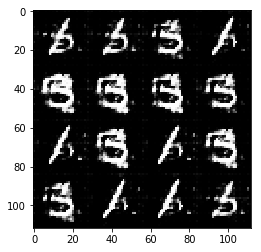

Epoch 2/2... Discriminator Loss: 0.1112... Generator Loss: 2.9217
Epoch 2/2... Discriminator Loss: 0.0824... Generator Loss: 4.1367
Epoch 2/2... Discriminator Loss: 0.1127... Generator Loss: 3.9866
Epoch 2/2... Discriminator Loss: 0.8270... Generator Loss: 1.0133
Epoch 2/2... Discriminator Loss: 0.2228... Generator Loss: 2.3905
Epoch 2/2... Discriminator Loss: 0.0562... Generator Loss: 3.6375
Epoch 2/2... Discriminator Loss: 0.0612... Generator Loss: 3.5324
Epoch 2/2... Discriminator Loss: 0.0593... Generator Loss: 3.7440
Epoch 2/2... Discriminator Loss: 0.1463... Generator Loss: 2.6959
Epoch 2/2... Discriminator Loss: 0.0632... Generator Loss: 3.7389


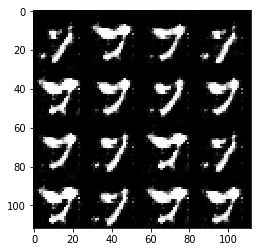

Epoch 2/2... Discriminator Loss: 0.1079... Generator Loss: 3.9668
Epoch 2/2... Discriminator Loss: 0.1379... Generator Loss: 2.6778
Epoch 2/2... Discriminator Loss: 0.0717... Generator Loss: 3.1765
Epoch 2/2... Discriminator Loss: 0.1153... Generator Loss: 2.8122
Epoch 2/2... Discriminator Loss: 0.1050... Generator Loss: 4.2814
Epoch 2/2... Discriminator Loss: 0.0850... Generator Loss: 3.3405
Epoch 2/2... Discriminator Loss: 0.1159... Generator Loss: 2.9157


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 0.1800... Generator Loss: 2.3057
Epoch 1/1... Discriminator Loss: 0.1979... Generator Loss: 2.6380
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.7117
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.2776
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.8573
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.3618
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.4702
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.8482


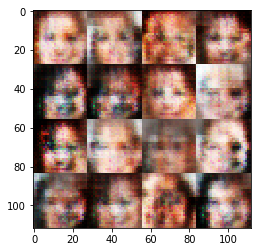

Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.2794
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.4074


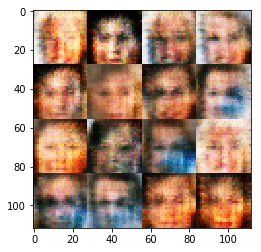

Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.6521... Generator Loss: 0.3197
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.2507
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 0.9611


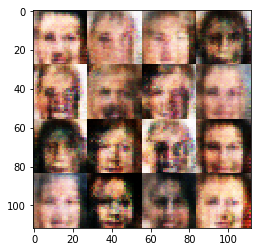

Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.7994


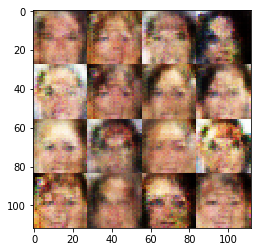

Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 0.9221


In [101]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.